# Training a CNN on the MNIST Dataset
By Justin Wong

## References: 

- [Keras Sequential Model](https://keras.io/guides/sequential_model/)

- [Explanation for CNN Dropouts to Prevent Overfitting](https://towardsdatascience.com/machine-learning-tpart-20-dropout-keras-layers-explained-8c9f6dc4c9ab)

- [Dimensionality Reduction via MaxPooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s#:~:text=Introducing%20max%20pooling,from%20the%20previous%20convolutional%20layer.)

- [Purpose of Flatten](https://www.tutorialspoint.com/keras/keras_flatten_layers.htm)

- [CNN Model Inspiration](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/)

## Imports

In [165]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import KFold
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import pyplot
import matplotlib.image as mpimg

## Loading the mnist database images from and reshaping

In [37]:

batch_size  = 128
num_classes = 10
epoches     = 12

# input image dimensions
img_rows, img_cols = 28, 28
def load_dataset():
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(x_train.shape[0], 28,28,1)
    x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1)

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], ' train samples')
    print(x_test.shape[0], ' test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test

MNIST = load_dataset()

x_train shape: (60000, 28, 28, 1)
60000  train samples
10000  test samples


In [13]:
## looking at y_train
MNIST[1], MNIST[1][0], len(MNIST[1][0])
 

(array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 10)

## Taking a look at the individual images

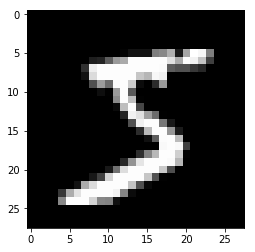

In [38]:
ith_image = 0 # this number can range from 0 to 59999
img = x_train[ith_image]
img_nparr = np.array(img, dtype='float')
pixels = img_nparr.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

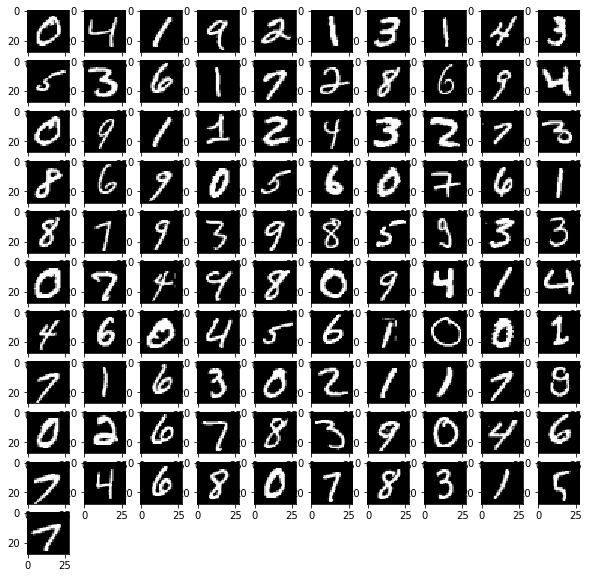

In [39]:
# normalize pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

def display_up_to_n_images(n):
    closest_square = round(np.sqrt(n))
    w=closest_square
    h=closest_square+1
    fig=plt.figure(figsize=(10, 10))
    columns = closest_square
    rows = closest_square+1
    for i in range(1, n+1):
        img = x_train[i]
        img_nparr = np.array(img, dtype='float')
        pixels = img_nparr.reshape((28, 28))
        fig.add_subplot(rows, columns, i)
        plt.imshow(pixels, cmap='gray')
    plt.show()
display_up_to_n_images(101)

## Designing the CNN Models

This was inspired by https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

In [114]:
## Different variations of the CNN

def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def improved_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)) )
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

## increeased depth and more layers with batch normalization
def playground_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def more_depth_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def dropout_model():
    model = Sequential()
    model.add(Dropout(.2, input_shape=(28, 28, 1)))
    model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Training and Testing the model on multuple epochs individually

In [43]:
base = base_model()
base.fit(x_train, y_train, batch_size=batch_size, epochs=epoches, verbose=1, validation_data=(x_test, y_test))
base_score = base.evaluate(x_test, y_test, verbose=0)
print('Test loss', base_score[0])
print('Test accuracy', base_score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 11s 178us/step - loss: 14.4324 - acc: 0.1046 - val_loss: 14.4612 - val_acc: 0.1028
Epoch 2/12
60000/60000 [==============================] - 10s 165us/step - loss: 14.4351 - acc: 0.1044 - val_loss: 14.4612 - val_acc: 0.1028
Epoch 3/12
60000/60000 [==============================] - 10s 166us/step - loss: 14.4351 - acc: 0.1044 - val_loss: 14.4612 - val_acc: 0.1028
Epoch 4/12
60000/60000 [==============================] - 10s 166us/step - loss: 14.4351 - acc: 0.1044 - val_loss: 14.4612 - val_acc: 0.1028
Epoch 5/12
60000/60000 [==============================] - 10s 165us/step - loss: 14.4351 - acc: 0.1044 - val_loss: 14.4612 - val_acc: 0.1028
Epoch 6/12
60000/60000 [==============================] - 10s 163us/step - loss: 14.4351 - acc: 0.1044 - val_loss: 14.4612 - val_acc: 0.1028
Epoch 7/12
60000/60000 [==============================] - 15s 244us/step - loss: 14.4351 - acc: 0.1044 -

In [42]:
improved = improved_model()
improved.fit(x_train, y_train, batch_size=batch_size, epochs=epoches, verbose=1, validation_data=(x_test, y_test))
improved_score = improved.evaluate(x_test, y_test, verbose=0)
print('Test loss', improved_score[0])
print('Test accuracy', improved_score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 55s 915us/step - loss: 1.7436 - acc: 0.8179 - val_loss: 0.0833 - val_acc: 0.9752
Epoch 2/12
60000/60000 [==============================] - 55s 913us/step - loss: 0.1477 - acc: 0.9581 - val_loss: 0.0520 - val_acc: 0.9842
Epoch 3/12
60000/60000 [==============================] - 53s 883us/step - loss: 0.1067 - acc: 0.9691 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 4/12
60000/60000 [==============================] - 54s 892us/step - loss: 0.0876 - acc: 0.9743 - val_loss: 0.0479 - val_acc: 0.9848
Epoch 5/12
60000/60000 [==============================] - 54s 895us/step - loss: 0.0743 - acc: 0.9784 - val_loss: 0.0467 - val_acc: 0.9847
Epoch 6/12
60000/60000 [==============================] - 53s 876us/step - loss: 0.0676 - acc: 0.9802 - val_loss: 0.0391 - val_acc: 0.9876
Epoch 7/12
60000/60000 [==============================] - 56s 929us/step - loss: 0.0602 - acc: 0.9821 - val_loss: 0.

In [54]:
playground = playground_model()
playground.fit(x_train, y_train, batch_size=batch_size, epochs=epoches, verbose=1, validation_data=(x_test, y_test))
playground_score = playground.evaluate(x_test, y_test, verbose=0)
print('Test loss', playground_score[0])
print('Test accuracy', playground_score[1])

W0916 17:15:33.213418 4619341248 deprecation_wrapper.py:119] From /Library/Python/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 33s 547us/step - loss: 0.1456 - acc: 0.9580 - val_loss: 0.0662 - val_acc: 0.9800
Epoch 2/12
60000/60000 [==============================] - 32s 530us/step - loss: 0.0488 - acc: 0.9867 - val_loss: 0.0525 - val_acc: 0.9828
Epoch 3/12
60000/60000 [==============================] - 31s 524us/step - loss: 0.0302 - acc: 0.9929 - val_loss: 0.0460 - val_acc: 0.9860
Epoch 4/12
60000/60000 [==============================] - 31s 517us/step - loss: 0.0193 - acc: 0.9957 - val_loss: 0.0435 - val_acc: 0.9862
Epoch 5/12
60000/60000 [==============================] - 31s 516us/step - loss: 0.0131 - acc: 0.9974 - val_loss: 0.0397 - val_acc: 0.9860
Epoch 6/12
60000/60000 [==============================] - 31s 518us/step - loss: 0.0092 - acc: 0.9986 - val_loss: 0.0418 - val_acc: 0.9869
Epoch 7/12
60000/60000 [==============================] - 30s 505us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.

In [61]:
more_depth = more_depth_model()
more_depth.fit(x_train, y_train, batch_size=batch_size, epochs=epoches, verbose=1, validation_data=(x_test, y_test))
more_depth_score = more_depth_score.evaluate(x_test, y_test, verbose=0)
print('Test loss', more_depth_score[0])
print('Test accuracy', more_depth_score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 65s 1ms/step - loss: 0.4799 - acc: 0.8824 - val_loss: 0.0580 - val_acc: 0.9822
Epoch 2/12
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1088 - acc: 0.9688 - val_loss: 0.0393 - val_acc: 0.9881
Epoch 3/12
60000/60000 [==============================] - 66s 1ms/step - loss: 0.0750 - acc: 0.9778 - val_loss: 0.0329 - val_acc: 0.9891
Epoch 4/12
60000/60000 [==============================] - 73s 1ms/step - loss: 0.0596 - acc: 0.9821 - val_loss: 0.0421 - val_acc: 0.9865
Epoch 5/12
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0508 - acc: 0.9852 - val_loss: 0.0227 - val_acc: 0.9921
Epoch 6/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0430 - acc: 0.9871 - val_loss: 0.0239 - val_acc: 0.9927
Epoch 7/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0369 - acc: 0.9886 - val_loss: 0.0275 - val_acc

In [ ]:
dropout = dropout_model()
dropout.fit(x_train, y_train, batch_size=batch_size, epochs=epoches, verbose=1, validation_data=(x_test, y_test))
dropout_score = dropout.evaluate(x_test, y_test, verbose=0)
print('Test loss', dropout_score[0])
print('Test accuracy', dropout_score[1])

## Evaluating the model with entropy loss using 5 fold cross validation

In [116]:
# evaluate a model using k-fold cross-validation
def evaluate_model(model, dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    k = 1
    for train_ix, test_ix in kfold.split(dataX):
        # select rows for train and test
        x_train, y_train, x_test, y_test = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(x_train, y_train, epochs=epoches, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)
        # evaluate model
        loss, acc = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss', loss)
        print('Test accuracy', acc)
        print('{k}th fold accuracy > {acc}>%'.format(k=k,acc=acc*100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
        k+=1
    return scores, histories

## Plotting charts, entropy loss and accuracy

In [87]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['acc'], color='blue', label='train')
        plt.plot(histories[i].history['val_acc'], color='orange', label='test')
    plt.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

## Evaluating Results

1. Loading MNIST data set
2. Evaluating the data by training and testing
3. Viewing Results with Loss and Accuracy Charts

### Prepraring data

In [31]:
# load dataset
train_x, train_y, test_x, test_y = load_dataset()
# prepare pixel data
train_x, test_x = prep_pixels(train_x, test_x)


x_train shape: (60000, 28, 28, 1)
60000  train samples
10000  test samples


### Evaluating models and displaying results

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 10s 201us/step - loss: 0.2777 - acc: 0.9163 - val_loss: 0.1411 - val_acc: 0.9580
Epoch 2/12
48000/48000 [==============================] - 8s 173us/step - loss: 0.1142 - acc: 0.9661 - val_loss: 0.1043 - val_acc: 0.9683
Epoch 3/12
48000/48000 [==============================] - 8s 164us/step - loss: 0.0806 - acc: 0.9764 - val_loss: 0.0894 - val_acc: 0.9728
Epoch 4/12
48000/48000 [==============================] - 8s 169us/step - loss: 0.0624 - acc: 0.9821 - val_loss: 0.0723 - val_acc: 0.9781
Epoch 5/12
48000/48000 [==============================] - 8s 170us/step - loss: 0.0503 - acc: 0.9856 - val_loss: 0.0681 - val_acc: 0.9798
Epoch 6/12
48000/48000 [==============================] - 8s 170us/step - loss: 0.0417 - acc: 0.9877 - val_loss: 0.0844 - val_acc: 0.9755
Epoch 7/12
48000/48000 [==============================] - 8s 174us/step - loss: 0.0357 - acc: 0.9896 - val_loss: 0.0590 -

48000/48000 [==============================] - 8s 170us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 8.6388e-04 - val_acc: 1.0000
Epoch 9/12
48000/48000 [==============================] - 8s 171us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 8.8537e-04 - val_acc: 0.9999
Epoch 10/12
48000/48000 [==============================] - 8s 168us/step - loss: 9.7892e-04 - acc: 1.0000 - val_loss: 9.1627e-04 - val_acc: 1.0000
Epoch 11/12
48000/48000 [==============================] - 8s 167us/step - loss: 9.5227e-04 - acc: 1.0000 - val_loss: 9.0684e-04 - val_acc: 0.9999
Epoch 12/12
48000/48000 [==============================] - 8s 171us/step - loss: 9.3894e-04 - acc: 1.0000 - val_loss: 9.5857e-04 - val_acc: 0.9999
Test loss 0.0009585712122558713
Test accuracy 0.9999166666666667
> 99.992


/Library/Python/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


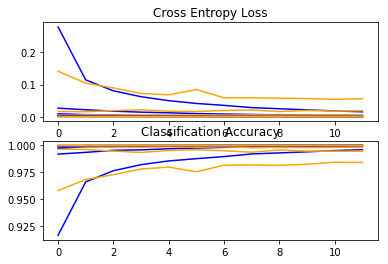

Accuracy: mean=99.543 std=0.595, n=5


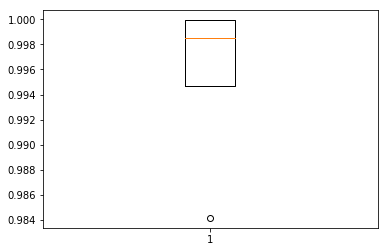

In [89]:
# evaluate base model
scores, histories = evaluate_model(base_model(), train_x, train_y)

# # learning curves
summarize_diagnostics(histories)

# # summarize estimated performance
summarize_performance(scores)
# histories[0].history

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 46s 953us/step - loss: 0.3201 - acc: 0.9002 - val_loss: 0.0803 - val_acc: 0.9761
Epoch 2/12
48000/48000 [==============================] - 46s 962us/step - loss: 0.1048 - acc: 0.9690 - val_loss: 0.0625 - val_acc: 0.9809
Epoch 3/12
48000/48000 [==============================] - 44s 922us/step - loss: 0.0808 - acc: 0.9751 - val_loss: 0.0545 - val_acc: 0.9845
Epoch 4/12
48000/48000 [==============================] - 43s 901us/step - loss: 0.0647 - acc: 0.9806 - val_loss: 0.0519 - val_acc: 0.9844
Epoch 5/12
48000/48000 [==============================] - 44s 913us/step - loss: 0.0562 - acc: 0.9831 - val_loss: 0.0455 - val_acc: 0.9870
Epoch 6/12
48000/48000 [==============================] - 43s 898us/step - loss: 0.0511 - acc: 0.9845 - val_loss: 0.0431 - val_acc: 0.9872
Epoch 7/12
48000/48000 [==============================] - 43s 905us/step - loss: 0.0475 - acc: 0.9860 - val_loss: 0.

48000/48000 [==============================] - 44s 916us/step - loss: 0.0186 - acc: 0.9937 - val_loss: 0.0051 - val_acc: 0.9982
Epoch 9/12
48000/48000 [==============================] - 47s 988us/step - loss: 0.0193 - acc: 0.9939 - val_loss: 0.0079 - val_acc: 0.9973
Epoch 10/12
48000/48000 [==============================] - 45s 938us/step - loss: 0.0181 - acc: 0.9941 - val_loss: 0.0075 - val_acc: 0.9976
Epoch 11/12
48000/48000 [==============================] - 46s 953us/step - loss: 0.0196 - acc: 0.9939 - val_loss: 0.0073 - val_acc: 0.9977
Epoch 12/12
48000/48000 [==============================] - 43s 887us/step - loss: 0.0178 - acc: 0.9943 - val_loss: 0.0065 - val_acc: 0.9981
Test loss 0.006542348719517728
Test accuracy 0.9980833333333333
> 99.808


/Library/Python/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


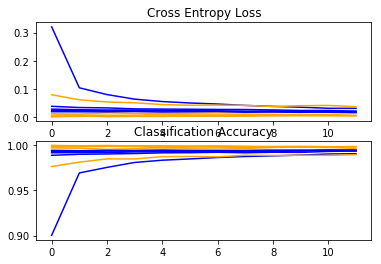

Accuracy: mean=99.513 std=0.327, n=5


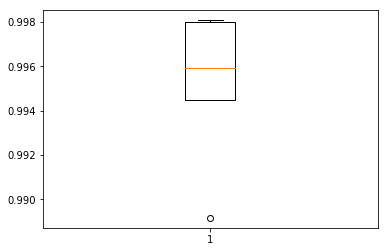

In [90]:
# evaluate improved model
improved_scores, improved_histories = evaluate_model(improved_model(), train_x, train_y)

# learning curves
summarize_diagnostics(improved_histories)

# summarize estimated performance
summarize_performance(improved_scores)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 27s 559us/step - loss: 0.1802 - acc: 0.9471 - val_loss: 0.0957 - val_acc: 0.9739
Epoch 2/12
48000/48000 [==============================] - 24s 510us/step - loss: 0.0637 - acc: 0.9826 - val_loss: 0.0663 - val_acc: 0.9805
Epoch 3/12
48000/48000 [==============================] - 24s 507us/step - loss: 0.0402 - acc: 0.9891 - val_loss: 0.0593 - val_acc: 0.9833
Epoch 4/12
48000/48000 [==============================] - 26s 551us/step - loss: 0.0266 - acc: 0.9934 - val_loss: 0.0546 - val_acc: 0.9834
Epoch 5/12
48000/48000 [==============================] - 29s 597us/step - loss: 0.0174 - acc: 0.9966 - val_loss: 0.0506 - val_acc: 0.9854
Epoch 6/12
48000/48000 [==============================] - 27s 573us/step - loss: 0.0113 - acc: 0.9985 - val_loss: 0.0504 - val_acc: 0.9851
Epoch 7/12
48000/48000 [==============================] - 34s 713us/step - loss: 0.0079 - acc: 0.9992 - val_loss: 0.

Epoch 7/12
48000/48000 [==============================] - 25s 514us/step - loss: 6.2823e-04 - acc: 1.0000 - val_loss: 1.6748e-04 - val_acc: 1.0000
Epoch 8/12
48000/48000 [==============================] - 26s 541us/step - loss: 6.1296e-04 - acc: 1.0000 - val_loss: 1.6195e-04 - val_acc: 1.0000
Epoch 9/12
48000/48000 [==============================] - 26s 540us/step - loss: 6.1998e-04 - acc: 1.0000 - val_loss: 1.6522e-04 - val_acc: 1.0000
Epoch 10/12
48000/48000 [==============================] - 26s 544us/step - loss: 6.1415e-04 - acc: 1.0000 - val_loss: 1.6912e-04 - val_acc: 1.0000
Epoch 11/12
48000/48000 [==============================] - 25s 526us/step - loss: 6.1977e-04 - acc: 1.0000 - val_loss: 1.6307e-04 - val_acc: 1.0000
Epoch 12/12
48000/48000 [==============================] - 26s 536us/step - loss: 5.9131e-04 - acc: 1.0000 - val_loss: 1.6381e-04 - val_acc: 1.0000
Test loss 0.00016381270726196817
Test accuracy 1.0
> 100.000


/Library/Python/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


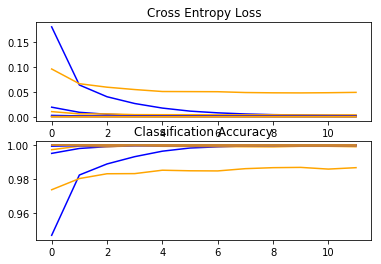

Accuracy: mean=99.723 std=0.517, n=5


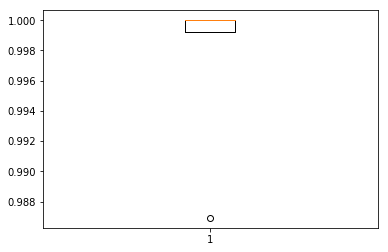

In [91]:
# evaluate playground model
playground_scores, playground_histories = evaluate_model(playground_model(), train_x, train_y)

# learning curves
summarize_diagnostics(playground_histories)

# summarize estimated performance
summarize_performance(playground_scores)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 66s 1ms/step - loss: 0.3552 - acc: 0.8851 - val_loss: 0.0833 - val_acc: 0.9732
Epoch 2/12
48000/48000 [==============================] - 53s 1ms/step - loss: 0.1039 - acc: 0.9687 - val_loss: 0.0543 - val_acc: 0.9833
Epoch 3/12
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0738 - acc: 0.9783 - val_loss: 0.0420 - val_acc: 0.9877
Epoch 4/12
48000/48000 [==============================] - 59s 1ms/step - loss: 0.0606 - acc: 0.9819 - val_loss: 0.0406 - val_acc: 0.9885
Epoch 5/12
48000/48000 [==============================] - 57s 1ms/step - loss: 0.0518 - acc: 0.9842 - val_loss: 0.0377 - val_acc: 0.9900
Epoch 6/12
48000/48000 [==============================] - 58s 1ms/step - loss: 0.0443 - acc: 0.9866 - val_loss: 0.0371 - val_acc: 0.9894
Epoch 7/12
48000/48000 [==============================] - 61s 1ms/step - loss: 0.0391 - acc: 0.9886 - val_loss: 0.0338 - val_acc

Epoch 9/12
48000/48000 [==============================] - 51s 1ms/step - loss: 0.0058 - acc: 0.9982 - val_loss: 0.0013 - val_acc: 0.9996
Epoch 10/12
48000/48000 [==============================] - 51s 1ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0022 - val_acc: 0.9992
Epoch 11/12
48000/48000 [==============================] - 52s 1ms/step - loss: 0.0059 - acc: 0.9982 - val_loss: 0.0024 - val_acc: 0.9991
Epoch 12/12
48000/48000 [==============================] - 52s 1ms/step - loss: 0.0067 - acc: 0.9981 - val_loss: 0.0018 - val_acc: 0.9993
Test loss 0.0017852809057230465
Test accuracy 0.9993333333333333
> 99.933


/Library/Python/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


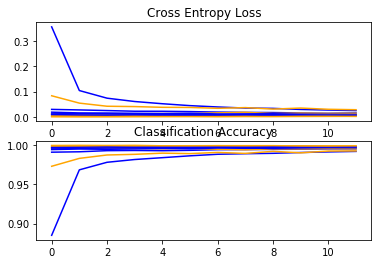

Accuracy: mean=99.692 std=0.244, n=5


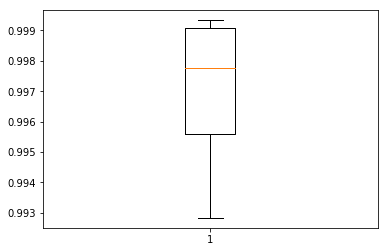

In [92]:
# evaluate improved model
more_depth_scores, more_depth_histories = evaluate_model(more_depth_model(), train_x, train_y)

# learning curves
summarize_diagnostics(more_depth_histories)

# summarize estimated performance
summarize_performance(more_depth_scores)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 29s 614us/step - loss: 0.1736 - acc: 0.9482 - val_loss: 0.0866 - val_acc: 0.9742
Epoch 2/12
48000/48000 [==============================] - 26s 549us/step - loss: 0.0562 - acc: 0.9846 - val_loss: 0.0632 - val_acc: 0.9817
Epoch 3/12
48000/48000 [==============================] - 26s 539us/step - loss: 0.0341 - acc: 0.9917 - val_loss: 0.0551 - val_acc: 0.9833
Epoch 4/12
48000/48000 [==============================] - 25s 521us/step - loss: 0.0218 - acc: 0.9952 - val_loss: 0.0521 - val_acc: 0.9838
Epoch 5/12
48000/48000 [==============================] - 25s 525us/step - loss: 0.0142 - acc: 0.9974 - val_loss: 0.0554 - val_acc: 0.9832
Epoch 6/12
48000/48000 [==============================] - 25s 530us/step - loss: 0.0102 - acc: 0.9985 - val_loss: 0.0509 - val_acc: 0.9835
Epoch 7/12
48000/48000 [==============================] - 25s 519us/step - loss: 0.0068 - acc: 0.9993 - val_loss: 0.

48000/48000 [==============================] - 26s 549us/step - loss: 6.2063e-04 - acc: 1.0000 - val_loss: 1.4173e-04 - val_acc: 1.0000
Epoch 7/12
48000/48000 [==============================] - 26s 550us/step - loss: 6.1577e-04 - acc: 1.0000 - val_loss: 1.4295e-04 - val_acc: 1.0000
Epoch 8/12
48000/48000 [==============================] - 30s 632us/step - loss: 6.2519e-04 - acc: 1.0000 - val_loss: 1.4300e-04 - val_acc: 1.0000
Epoch 9/12
48000/48000 [==============================] - 30s 629us/step - loss: 5.9713e-04 - acc: 1.0000 - val_loss: 1.4049e-04 - val_acc: 1.0000
Epoch 10/12
48000/48000 [==============================] - 27s 558us/step - loss: 5.8953e-04 - acc: 1.0000 - val_loss: 1.4449e-04 - val_acc: 1.0000
Epoch 11/12
48000/48000 [==============================] - 34s 701us/step - loss: 5.8359e-04 - acc: 1.0000 - val_loss: 1.3682e-04 - val_acc: 1.0000
Epoch 12/12
48000/48000 [==============================] - 28s 577us/step - loss: 5.7225e-04 - acc: 1.0000 - val_loss: 1.3936e-

/Library/Python/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


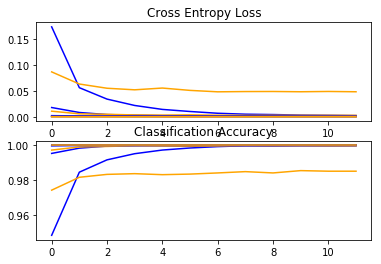

Accuracy: mean=99.698 std=0.591, n=5


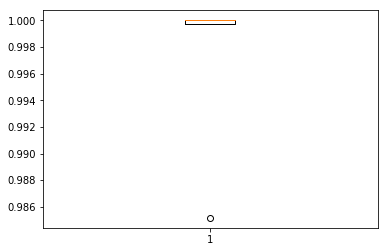

In [96]:
# evaluate improved model
more_depth_scores, more_depth_histories = evaluate_model(more_depth_model(), train_x, train_y)

# learning curves
summarize_diagnostics(more_depth_histories)

# summarize estimated performance
summarize_performance(more_depth_scores)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 30s 620us/step - loss: 0.2244 - acc: 0.9324 - val_loss: 0.2268 - val_acc: 0.9411
Epoch 2/12
48000/48000 [==============================] - 27s 562us/step - loss: 0.0889 - acc: 0.9741 - val_loss: 0.1533 - val_acc: 0.9604
Epoch 3/12
48000/48000 [==============================] - 29s 605us/step - loss: 0.0669 - acc: 0.9806 - val_loss: 0.0931 - val_acc: 0.9746
Epoch 4/12
48000/48000 [==============================] - 31s 637us/step - loss: 0.0533 - acc: 0.9845 - val_loss: 0.0967 - val_acc: 0.9725
Epoch 5/12
48000/48000 [==============================] - 28s 584us/step - loss: 0.0439 - acc: 0.9871 - val_loss: 0.0859 - val_acc: 0.9757
Epoch 6/12
48000/48000 [==============================] - 28s 576us/step - loss: 0.0379 - acc: 0.9887 - val_loss: 0.0795 - val_acc: 0.9759
Epoch 7/12
48000/48000 [==============================] - 28s 577us/step - loss: 0.0337 - acc: 0.9896 - val_loss: 0.

48000/48000 [==============================] - 26s 543us/step - loss: 0.0040 - acc: 0.9989 - val_loss: 0.0033 - val_acc: 0.9997
Epoch 9/12
48000/48000 [==============================] - 27s 553us/step - loss: 0.0045 - acc: 0.9988 - val_loss: 0.0033 - val_acc: 0.9998
Epoch 10/12
48000/48000 [==============================] - 26s 531us/step - loss: 0.0039 - acc: 0.9991 - val_loss: 0.0046 - val_acc: 0.9989
Epoch 11/12
48000/48000 [==============================] - 26s 550us/step - loss: 0.0041 - acc: 0.9990 - val_loss: 0.0032 - val_acc: 0.9997
Epoch 12/12
48000/48000 [==============================] - 25s 526us/step - loss: 0.0041 - acc: 0.9990 - val_loss: 0.0033 - val_acc: 0.9998
Test loss 0.0032593610016823124
Test accuracy 0.99975
> 99.975


/Library/Python/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


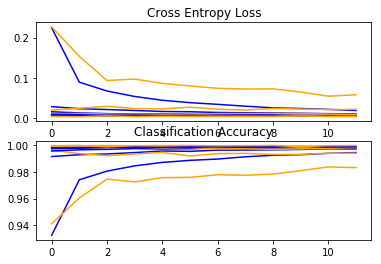

Accuracy: mean=99.485 std=0.617, n=5


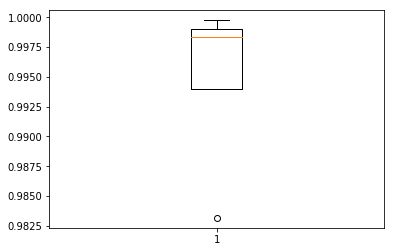

In [115]:
# evaluate dropout_model() model
dropout_scores, dropout_histories = evaluate_model(dropout_model(), train_x, train_y)

# learning curves
summarize_diagnostics(dropout_histories)

# summarize estimated performance
summarize_performance(dropout_scores)

In [117]:
best = more_depth_model()
def save_and_fit_best_model(model, name):
    # load dataset
    train_x, train_y, test_x, test_y = load_dataset()
    # prepare pixel data
    train_x, test_x = prep_pixels(train_x, test_x)
    
    print("Fitting model")
    model.fit(train_x, train_y, epochs=epoches, batch_size=batch_size, verbose=1)
    print("Finished fitting model")
    
    model.save(name)
    
# save_and_fit_best_model(best, "three_sigma_model.h5")
# save_and_fit_best_model(playground_model(), "playground.h5")
save_and_fit_best_model(dropout_model(), "dropout.h5")

x_train shape: (60000, 28, 28, 1)
60000  train samples
10000  test samples
Fitting model
Epoch 1/12
60000/60000 [==============================] - 34s 562us/step - loss: 0.2113 - acc: 0.9381
Epoch 2/12
60000/60000 [==============================] - 30s 500us/step - loss: 0.0875 - acc: 0.9741
Epoch 3/12
60000/60000 [==============================] - 30s 497us/step - loss: 0.0655 - acc: 0.9804
Epoch 4/12
60000/60000 [==============================] - 30s 507us/step - loss: 0.0533 - acc: 0.9838
Epoch 5/12
60000/60000 [==============================] - 30s 502us/step - loss: 0.0440 - acc: 0.9868
Epoch 6/12
60000/60000 [==============================] - 30s 507us/step - loss: 0.0376 - acc: 0.9890
Epoch 7/12
60000/60000 [==============================] - 30s 494us/step - loss: 0.0329 - acc: 0.9900
Epoch 8/12
60000/60000 [==============================] - 30s 504us/step - loss: 0.0283 - acc: 0.9916
Epoch 9/12
60000/60000 [==============================] - 30s 504us/step - loss: 0.0259 - acc: 

In [124]:
def load_and_evaluate_model(name):
    # load dataset
    train_x, train_y, test_x, test_y = load_dataset()
    # prepare pixel data
    train_x, test_x = prep_pixels(train_x, test_x)
    
    # loading model
    model = load_model(name)
    
    # evaluate
    loss, acc = model.evaluate(test_x, test_y, verbose=0)
    print('Accuracy on test data > %.3f' % (acc * 100.0))


In [108]:
load_and_evaluate_model('playground.h5')

x_train shape: (60000, 28, 28, 1)
60000  train samples
10000  test samples
Accuracy on test data > 98.670


In [109]:
load_and_evaluate_model('three_sigma_model.h5')

x_train shape: (60000, 28, 28, 1)
60000  train samples
10000  test samples
Accuracy on test data > 98.900


In [125]:
load_and_evaluate_model('dropout.h5')

x_train shape: (60000, 28, 28, 1)
60000  train samples
10000  test samples
Accuracy on test data > 98.220


## Using the Model for uploaded numbers

In [128]:

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

### My handwritten 5 was correctly predicted.

In [161]:
# predict the class
fn = "5.png" # some uploaded file
img = load_image(fn)

playground = load_model('playground.h5')
three_sig = load_model('three_sigma_model.h5')
dropout = load_model('dropout.h5')

playground_predicted_digit = playground.predict_classes(img)
three_sig_predicted_digit  = three_sig.predict_classes(img)
dropout_predicted_digit = dropout.predict_classes(img)

print("The playground model predicts {fn} was a {n}".format(fn=fn, n=playground_predicted_digit))
print("The three_sig model predicts {fn} was a {n}".format(fn=fn, n=three_sig_predicted_digit))
print("The dropout model predicts {fn} was a {n}".format(fn=fn, n=dropout_predicted_digit))

The playground model predicts 5.png was a [5]
The three_sig model predicts 5.png was a [5]
The dropout model predicts 5.png was a [5]


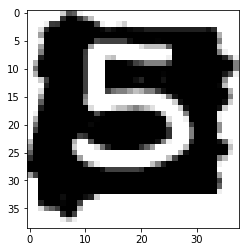

In [166]:
img = mpimg.imread('5.png')
imgplot = plt.imshow(img)
plt.show()

### But looks like 8 got confused with 3 for all 3 models.

In [158]:
# predict the class
fn = "8.png" # some uploaded file
img = load_image(fn)

playground = load_model('playground.h5')
three_sig = load_model('three_sigma_model.h5')
dropout = load_model('dropout.h5')

playground_predicted_digit = playground.predict_classes(img)
three_sig_predicted_digit  = three_sig.predict_classes(img)
dropout_predicted_digit = dropout.predict_classes(img)

print("The playground model predicts {fn} was a {n}".format(fn=fn, n=playground_predicted_digit))
print("The three_sig model predicts {fn} was a {n}".format(fn=fn, n=three_sig_predicted_digit))
print("The dropout model predicts {fn} was a {n}".format(fn=fn, n=dropout_predicted_digit))

/Library/Python/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The playground model predicts 8.png was a [3]
The three_sig model predicts 8.png was a [3]
The dropout model predicts 8.png was a [3]


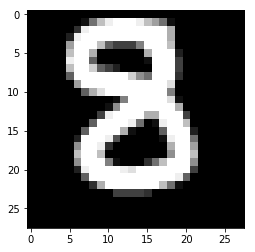

In [167]:
img = mpimg.imread('8.png')
imgplot = plt.imshow(img)
plt.show()

### And 3 looks good.

In [168]:
# predict the class
fn = "3.png" # some uploaded file
img = load_image(fn)

playground = load_model('playground.h5')
three_sig = load_model('three_sigma_model.h5')
dropout = load_model('dropout.h5')

playground_predicted_digit = playground.predict_classes(img)
three_sig_predicted_digit  = three_sig.predict_classes(img)
dropout_predicted_digit = dropout.predict_classes(img)

print("The playground model predicts {fn} was a {n}".format(fn=fn, n=playground_predicted_digit))
print("The three_sig model predicts {fn} was a {n}".format(fn=fn, n=three_sig_predicted_digit))
print("The dropout model predicts {fn} was a {n}".format(fn=fn, n=dropout_predicted_digit))

/Library/Python/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The playground model predicts 3.png was a [3]
The three_sig model predicts 3.png was a [3]
The dropout model predicts 3.png was a [3]


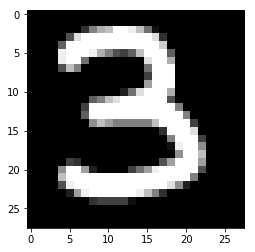

In [169]:
img = mpimg.imread('3.png')
imgplot = plt.imshow(img)
plt.show()